In [1]:
%config IPCompleter.greedy=True

In [2]:
import constants
from utils.file_utils import load_pickle_from_disk
import pandas as pd
import numpy as np
import os
import re
import openslide
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings

In [3]:
def create_preds_array(slide_name):
    slide_to_dims = load_pickle_from_disk(f"{constants.VISUALIZATION_HELPER_FILE_FOLDER}/slide_name_to_tile_dims_map")
    dims = slide_to_dims[slide_name]
    preds_array = np.full((*dims, constants.NUM_CLASSES), fill_value=np.nan, dtype=np.float32)
    
    preds_file = f"{constants.PREDICTIONS_DIRECTORY}/{slide_name}.csv"
    df = pd.read_csv(preds_file)
    patch_to_coords = load_pickle_from_disk(f"{constants.VISUALIZATION_HELPER_FILE_FOLDER}/patch_name_to_coords_map")
    coords_list = []
    
    for _, row in df.iterrows():
        coords = patch_to_coords[row['filepath'].replace('.jpg', '')]
        preds_array[coords] = np.array(row[3:])
        coords_list.append(coords)
    
    return preds_array, coords_list, dims, df
    

In [4]:
def get_confusion_matrix(slide, preds_df):
    confusion_mat = np.zeros((constants.NUM_CLASSES, constants.NUM_CLASSES), dtype=np.int32)

    for _,row in preds_df.iterrows():
        pred = np.argmax(np.array(row[3:]))
        confusion_mat[row['labels'], pred] +=1
        
    return confusion_mat

# from https://gist.github.com/zachguo/10296432

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrices"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}s".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [5]:
def knn_smooth(preds_array, coords, knn_range=1, smooth_factor=0.7):
    result_array = np.copy(preds_array)
    
    for c in coords:
        x, y = c
        adj = preds_array[max(0,x-knn_range):x+knn_range+1, max(y-knn_range,0):y+knn_range+1]
        if smooth_factor != 1:
            weights = np.invert(np.isnan(adj)) * smooth_factor
            weights[knn_range, knn_range] = 1
            result_array[c] = np.nansum(adj * weights, axis=(0,1)) / np.sum(weights, axis=(0,1))
        else:
            result_array[c] = np.nanmean(adj, axis=(0,1))
    
    return result_array

In [6]:
def estimate_surface_areas(preds_array, label_to_class):
    p = np.argmax(preds_array, axis=-1)
    pred_class = np.where(np.isnan(preds_array[:,:,0]), preds_array[:,:,0], p)
    
    num_per_class = defaultdict(int)
    
    
    for label in label_to_class.keys():
        num_per_class[label_to_class[label]] = np.sum(pred_class == label)
    
    patch_area = constants.PATCH_SIZE ** 2
    sa_per_class = {c:n*patch_area for c,n in num_per_class.items()}
        
    return num_per_class, sa_per_class
    

In [7]:
def get_sa_for_slide(slide_name):
    path = f"{constants.SA_CSV_DIRECTORY}/{slide_name}.csv"
    sa_df = pd.read_csv(path)
    sa_df.columns = ['class', 'area']
    sa_by_class = sa_df.groupby('class').sum()
    sa_dict = defaultdict(int)
    
    for class_name, val in sa_by_class.iterrows():
        area = val[0]
        sa_dict[class_name] = area
    
    return sa_dict

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def visualize_predictions(preds_array, slide, class_to_label, label_to_class, dims, mode='jupyter'):
    path = get_slide_path(slide)
    slide_obj = openslide.OpenSlide(path)
    im = slide_obj.get_thumbnail((dims[1], dims[0])).resize((dims[1], dims[0])).convert('L')
    dpi = 100
    dims_in = (dims[0] / dpi, dims[1] / dpi)
    
    p = np.argmax(preds_array, axis=-1)
    pred_class = np.where(np.isnan(preds_array[:,:,0]), preds_array[:,:,0], p)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
        pred_conf = np.nanmax(preds_array, axis=-1)
    
    default_confs = np.where(pred_class==class_to_label[constants.DEFAULT_CLASS_NAME], 
                                 pred_conf, np.full(pred_class.shape, np.nan))
    large_confs = np.where(pred_class==class_to_label['large_tumor'], pred_conf, np.full(pred_class.shape, np.nan))
    small_confs = np.where(pred_class==class_to_label['small_tumor'], pred_conf, np.full(pred_class.shape, np.nan))
    
    
    fig = plt.figure(figsize=dims_in, dpi=dpi)
    ax = plt.gca()
    ax.imshow(im, cmap=plt.cm.gray)
    
    
    default_im = ax.imshow(default_confs, interpolation='none', cmap=plt.cm.Greens, vmin=0, vmax=1, alpha=0.5)
    large_im = ax.imshow(large_confs, interpolation='none', cmap=plt.cm.Blues, vmin=0, vmax=1, alpha=0.5)
    small_im = ax.imshow(small_confs, interpolation='none', cmap=plt.cm.Reds, vmin=0, vmax=1, alpha=0.5)
    
    ax.set_title(f"{slide}")
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cax2 = divider.append_axes("right", size="5%", pad=.75)
    cax3 = divider.append_axes("right", size="5%", pad=.75)

    default_cbar = plt.colorbar(default_im, ticks=[0.0, 0.5, 1.0], cax=cax)
    default_cbar.ax.set_title('Normal', fontsize=8)

    large_cbar = plt.colorbar(large_im, ticks=[0.0, 0.5, 1.0], cax=cax2)
    large_cbar.ax.set_title('Large', fontsize=8)

    small_cbar = plt.colorbar(small_im, ticks=[0.0, 0.5, 1.0], cax=cax3)
    small_cbar.ax.set_title('Small', fontsize=8)
    
    if mode == 'jupyter':
        plt.show()
        plt.close()
        
    elif mode == 'save':
        viz_dir = f"{constants.VISUALIZATION_HELPER_FILE_FOLDER}/visualizations"
        if not os.path.isdir(viz_dir):
            os.makedirs(viz_dir)
        plt.savefig(f"{viz_dir}/{slide}.png")
        plt.close()
    
def process_label(label):
    return label.replace("_"," ").title()

def get_slide_path(slide):
    if "Scan" in slide:
        path = f"{constants.SLIDE_FILE_DIRECTORY}/" + "/".join(slide.split("_")) + f"/{slide}.qptiff"
    else:
        prefix = re.split("[0-9]+", slide)[0]
        img_num = int(re.findall("[0-9]+", slide)[0])

        path = f"{constants.SLIDE_FILE_DIRECTORY}/{prefix}{img_num:02}/{slide}.svs"
    return path

In [9]:
def get_metrics(num_per_class, sa_dict, preds_array, class_to_label):
    total_num = sum(list(num_per_class.values()))
    
    true_ls_ratio = sa_dict['large_tumor'] / (sa_dict['large_tumor'] + sa_dict['small_tumor'])
    
    pred_ls_ratio = num_per_class['large_tumor'] / (num_per_class['large_tumor'] + num_per_class['small_tumor'])

    
    print(f"Predicted Large-Small Ratio: {pred_ls_ratio:.2f}; True ratio: {true_ls_ratio:.2f}")
        
    return true_ls_ratio, pred_ls_ratio

In [10]:
def process_predictions(slide):
    preds_array, coords, dims, df = create_preds_array(slide)
    if constants.KNN_SMOOTH:
        preds_array = knn_smooth(preds_array, coords)
    
    confusion_matrix = get_confusion_matrix(slide, df)

    class_to_label = load_pickle_from_disk(f"{constants.VISUALIZATION_HELPER_FILE_FOLDER}/class_to_label")
    label_to_class = {v:k for k,v in class_to_label.items()}
    
    print_cm(confusion_matrix, labels = [label_to_class[i] for i in range(max(label_to_class.keys()) + 1)])

    num_per_class, sa_per_class = estimate_surface_areas(preds_array, label_to_class)

    visualize_predictions(preds_array, slide, class_to_label, label_to_class, dims)

    sa_dict = get_sa_for_slide(slide)
    true_ratio, pred_ratio = get_metrics(num_per_class, sa_dict, preds_array, class_to_label)
    return true_ratio, pred_ratio, confusion_matrix

In [22]:
def process_all_predictions():
    df = pd.DataFrame(columns=['slide', 'predicted_ratio', 'true_ratio'])
    
    confusion_mat = np.zeros((constants.NUM_CLASSES, constants.NUM_CLASSES), dtype=np.int32)
    for slide_file in os.listdir(constants.PREDICTIONS_DIRECTORY):
        if '.csv' not in slide_file:
            continue
        slide = slide_file.replace(".csv", "")
        print(f"Results for Slide {slide}")
        true, pred, confuse = process_predictions(slide)
        df = df.append({'slide':slide, 'predicted_ratio':pred, 'true_ratio':true}, ignore_index=True)
        
        confusion_mat += confuse
        
    class_to_label = load_pickle_from_disk(f"{constants.VISUALIZATION_HELPER_FILE_FOLDER}/class_to_label")
    label_to_class = {v:k for k,v in class_to_label.items()}
        
    print("Final Confusion Matrix")
    print_cm(confusion_mat, labels = [label_to_class[i] for i in range(max(label_to_class.keys()) + 1)])
    
    df.to_csv(os.path.join(constants.PREDICTIONS_DIRECTORY, "predicted_ratios.csv"))

         t/p        large_tumor normal_tissue   small_tumor normal_marrow 
      large_tumor          1791          4294          5955            14 
    normal_tissue            75          1025            53            76 
      small_tumor             0             0             0             0 
    normal_marrow            51          5226           285           222 
defaultdict(<class 'int'>, {'large_tumor': 1091, 'normal_tissue': 11174, 'small_tumor': 6652, 'normal_marrow': 150})


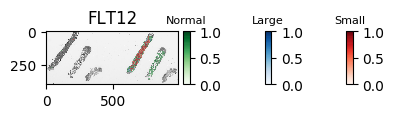

Predicted Large-Small Ratio: 0.14; True ratio: 1.00


(1.0, 0.1409014593826682, array([[1791, 4294, 5955,   14],
        [  75, 1025,   53,   76],
        [   0,    0,    0,    0],
        [  51, 5226,  285,  222]], dtype=int32))

In [24]:
slide = 'FLT12'
process_predictions(slide)

In [ ]:
process_all_predictions()